In [1]:
# jupyter config
%matplotlib inline

# Data manipulation
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Data prep for ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ML algos
from sklearn.decomposition import PCA

# ML models
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier # as skgb
import xgboost as xgb

# ML model evaluation
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix


### Data ingest

In [2]:
df_k = pd.read_csv('./data/data_kershaw_2017to2021.csv')
df_b = pd.read_csv('./data/data_buehler_2017to2021.csv')

print(df_k.shape, df_b.shape)
print(df_k.columns)
print(df_b.columns)
display(df_k.head(2))
display(df_b.head(2))

(12009, 92) (10600, 92)
Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1',
       'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'releas

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
0,SL,2021-10-01,86.2,1.52,6.22,"Kershaw, Clayton",543939,477132,double,hit_into_play,...,1,3,1,3,1,Standard,Standard,202.0,-0.097,0.888
1,FF,2021-10-01,89.1,1.39,6.17,"Kershaw, Clayton",543939,477132,NaN,ball,...,1,2,1,2,1,Standard,Standard,183.0,0.000,0.041


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
0,FF,2021-10-23,96.1,-0.88,5.74,"Buehler, Walker",645277,621111,strikeout,swinging_strike,...,1,1,4,4,1,Infield shift,Standard,202.0,-0.011,-0.138
1,CH,2021-10-23,91.4,-1.25,5.42,"Buehler, Walker",645277,621111,NaN,foul,...,1,1,4,4,1,Infield shift,Standard,232.0,0.000,-0.047


In [3]:
df_k['pitch_type'].value_counts()

FF    4945
SL    4600
CU    1894
CH      68
SI      43
Name: pitch_type, dtype: int64

In [4]:
df_b['pitch_type'].value_counts()

FF    4875
SL    1401
KC    1398
FC    1323
SI     985
CH     289
Name: pitch_type, dtype: int64

### Data cleaning

In [5]:
def select_features(df_in, feature_list_in):
    """
        Select a subset of features from which to build a 
        predictive model.
    """
    df_out = df_in[feature_list_in]
    return df_out


def remove_nans(df_in, col_list):
    """
        Deletes rows in df_in that contain NaNs in the columns in col_list
    """
    df_out = df_in.dropna(subset=[col_list])
    return df_out

def select_pitch_type_target(df_in, target_pitch_in):
    """
        Tags the pitch type given in 'target_pitch_in' as '1', 
        and all other pitch types as '0', in preparation
        for binary classification step
    """
    ### turn pitch_type into binary (to start with). Just: is FF or is not:
    df_out = df_in.copy()
    df_out['pitch_bin'] = 0
    # df_out.loc[df_out.pitch_type == 'FF', 'FF_bin'] = 1
    df_out.loc[df_out.pitch_type == target_pitch_in, 'pitch_bin'] = 1
    return df_out

In [6]:
# Parameters for data selection
feature_list = ['pitch_type', 'balls', 'strikes', 'game_year', 
                'batter', 'pitch_number', 'at_bat_number', 
                'home_score','away_score', 'if_fielding_alignment',
                'of_fielding_alignment', 'on_3b', 'on_2b', 'on_1b', 
                'outs_when_up' 
               ]
remove_nans_from_cols = 'pitch_type'
target_pitch_class = 'FF' #'CH' #'CU' #'SL' #'FF' #'SL' #'CU' #'FF' #'CU' #'FF'
test_size = 0.3
nan_strategy = 'fill_zero'

In [7]:
print(df_k.shape)
df_k = select_features(df_k, feature_list)
df_k = remove_nans(df_k, remove_nans_from_cols) ## a hack . . . 
df_k = select_pitch_type_target(df_k, target_pitch_class)
print(df_k.shape)

(12009, 92)
(11550, 16)


In [8]:
print(df_b.shape)
df_b = select_features(df_b, feature_list)
df_b = remove_nans(df_b, remove_nans_from_cols) ## a hack . . . 
df_b = select_pitch_type_target(df_b, target_pitch_class)
print(df_b.shape)

(10600, 92)
(10271, 16)


In [9]:
df_k['pitch_bin'].value_counts() #1=FF, 0=Other

0    6605
1    4945
Name: pitch_bin, dtype: int64

In [10]:
df_k['pitch_type']

0        SL
1        FF
2        SL
3        SL
4        FF
         ..
12004    FF
12005    CU
12006    FF
12007    FF
12008    FF
Name: pitch_type, Length: 11550, dtype: object

In [11]:
df_b['pitch_bin'].value_counts()

0    5396
1    4875
Name: pitch_bin, dtype: int64

### Prep data for ML

In [12]:
## num_train0, num_train1, frac_class1 = calc_class_imbal(y_train)

def calc_class_imbal(y_in):
    """
    Insert Function Description
    """
    df_ytrain = pd.DataFrame(y_in)
    df_ytrain.columns = ['y']
    df_y_0 = df_ytrain[df_ytrain['y'] == 0]
    df_y_1 = df_ytrain[df_ytrain['y'] == 1]
    num_train0_out = df_y_0.shape[0]
    num_train1_out = df_y_1.shape[0]
    frac_0 = num_train0_out / num_train1_out
    print(" ")
    print('num_train0_out: ', num_train0_out)
    print('num_train1_out: ', num_train1_out)
    print('frac_0: (num_train0_out / num_train1_out): ', frac_0)
    return frac_0

def standardize_data(X_train_in, X_test_in):
    """
    Insert Function Description
    """
    sc = StandardScaler()
    sc.fit(X_train_in)
    X_train_std_out = sc.transform(X_train_in)
    X_test_std_out = sc.transform(X_test_in)
    return X_train_std_out, X_test_std_out

def pca_dim_red(X_train_in, X_test_in):
    
    pca = PCA(n_components=2)
    X_train_pca_out = pca.fit_transform(X_train_in)
    pca.fit_transform(X_train_in)
    X_test_pca_out = pca.transform(X_test_in)
    
    return X_train_pca_out, X_test_pca_out

def create_X_y_dfs(df_in): 
    """
        Hard coded for this specific dataset (generalize later)
    """
    df_y_out = pd.DataFrame(df_in['pitch_bin'])
    df_X_out = df_in.drop(columns=['pitch_type', 'pitch_bin'], axis=1)
    return df_X_out, df_y_out

def create_numeric_and_onehot_features(df_in):
    """
    Insert Function Description
    """    
    df_out = pd.get_dummies(df_in)
    return df_out

def handle_nans(df_in, nan_strategy_in):
    """
    Insert Function Description
    """   
    df_out = df_in
    if (nan_strategy_in == 'fill_zero'):
        df_out = df_in.fillna(0)
    return df_out

def create_ml_data_splits(df_X_in, df_y_in, test_size_in):
    """
    Insert Function Description
    """
    X = df_X_in.values
    y = df_y_in.values
    X_train_out, X_test_out, y_train_out, y_test_out = train_test_split(X, y, test_size=test_size, 
                                                                        stratify=y) # random_state=1
    return X_train_out, X_test_out, y_train_out, y_test_out

In [13]:
test_size = 0.3
nan_strategy = 'fill_zero'

In [14]:
df_X_k, df_y_k = create_X_y_dfs(df_k)
df_X_k = create_numeric_and_onehot_features(df_X_k)
df_X_k = handle_nans(df_X_k, nan_strategy)

X_train_k, X_test_k, y_train_k, y_test_k = create_ml_data_splits(df_X_k, df_y_k, test_size) 
frac_class0_k = calc_class_imbal(y_train_k)

X_train_std_k, X_test_std_k = standardize_data(X_train_k, X_test_k)
X_train_pca_k, X_test_pca_k = pca_dim_red(X_train_std_k, X_test_std_k)

 
num_train0_out:  4623
num_train1_out:  3462
frac_0: (num_train0_out / num_train1_out):  1.3353552859618718


In [15]:
df_X_b, df_y_b = create_X_y_dfs(df_b)
df_X_b = create_numeric_and_onehot_features(df_X_b)
df_X_b = handle_nans(df_X_b, nan_strategy)

X_train_b, X_test_b, y_train_b, y_test_b = create_ml_data_splits(df_X_b, df_y_b, test_size) 
frac_class0_b = calc_class_imbal(y_train_b)

X_train_std_b, X_test_std_b = standardize_data(X_train_b, X_test_b)
X_train_pca_b, X_test_pca_b = pca_dim_red(X_train_std_b, X_test_std_b)

 
num_train0_out:  3777
num_train1_out:  3412
frac_0: (num_train0_out / num_train1_out):  1.1069753810082064


In [16]:
#gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)

clf_k = GradientBoostingClassifier()
clf_k.fit(X_train_k, y_train_k)
y_pred_k = clf_k.predict(X_test_k)

C:\Users\m85302\Anaconda3b\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [17]:
clf_b = GradientBoostingClassifier()
clf_b.fit(X_train_b, y_train_b)
y_pred_b = clf_b.predict(X_test_b)

C:\Users\m85302\Anaconda3b\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


### Evaluate ML models

In [18]:
def eval_ml_model(label, y_test_in, y_pred_in):
    """
    Evaluate maching learning (ML) model, binary classification
    """
    print(label)
    print(" ")
    
    score_accuracy = accuracy_score(y_test_in, y_pred_in)
    score_precision = precision_score(y_test_in, y_pred_in)
    score_recall = recall_score(y_test_in, y_pred_in)
    score_f1 = f1_score(y_test_in, y_pred_in)
    score_roc_auc = roc_auc_score(y_test_in, y_pred_in)
    score_confmat = confusion_matrix(y_test_in, y_pred_in)
    
    print('Accuracy: ', score_accuracy)
    print('Precision: ', score_precision)
    print('Recall: ', score_recall)
    print('F1: ', score_f1)
    print('ROC_AUC:', score_roc_auc)
    print(score_confmat)
    viz_confusion_matrix(score_confmat)
    print(" ")

In [19]:
def viz_confusion_matrix(confmat):
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    plt.xlabel('predicted label')
    plt.ylabel('true label')

    plt.tight_layout()
    # plt.savefig('./figures/confusion_matrix.png', dpi=300)
    plt.show()

Kershaw, Params: Default, Pitch: FF
 
Accuracy:  0.6756132756132757
Precision:  0.6694995278564684
Recall:  0.47808496291301417
F1:  0.5578284815106216
ROC_AUC: 0.650747829589706
[[1632  350]
 [ 774  709]]


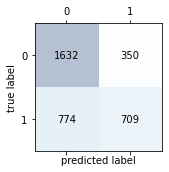

In [20]:
eval_ml_model('Kershaw, Params: Default, Pitch: ' + target_pitch_class, y_test_k, y_pred_k)

Buehler, Params: Default, Pitch: FF
 
Accuracy:  0.6200519143413368
Precision:  0.6315315315315315
Recall:  0.47915242652084755
F1:  0.5448892343567819
ROC_AUC: 0.6132636746563472
[[1210  409]
 [ 762  701]]


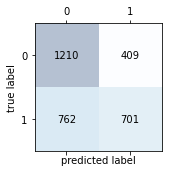

In [21]:
eval_ml_model('Buehler, Params: Default, Pitch: ' + target_pitch_class, y_test_b, y_pred_b)

Note: the baseline models are are particularly high performers . . . a topic for future research (work on data, approach, etc.)

### Domain switch

Predict Buehler's next pitch using a model trained on Kershaw's data

In [22]:
y_pred_b_withKersh = clf_k.predict(X_test_b)

Buehler w/ Kersh_model, Params: Default, Pitch: FF
 
Accuracy:  0.5791693705386113
Precision:  0.5949656750572082
Recall:  0.35543403964456594
F1:  0.44501497646555405
ROC_AUC: 0.5683902749180211
[[1265  354]
 [ 943  520]]


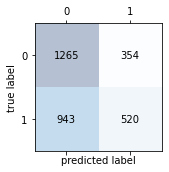

In [23]:
eval_ml_model('Buehler w/ Kersh_model, Params: Default, Pitch: ' + target_pitch_class, y_test_b, y_pred_b_withKersh)

### Domain adaptation

In [24]:
from adapt.instance_based import KLIEP

In [25]:
model = KLIEP(estimator=clf_k)

In [26]:
model.fit(X_train_k, y_train_k, X_train_b)

Fit weights...
Fit Estimator...


KLIEP(estimator=GradientBoostingClassifier())

In [27]:
y_pred_b_kleip = model.predict(X_test_b)

Buehler w/ adapt_kliep, Params: Default, Pitch: FF
 
Accuracy:  0.5496430889033095
Precision:  0.5261324041811847
Recall:  0.5160628844839371
F1:  0.5210489993098689
ROC_AUC: 0.548025265589714
[[939 680]
 [708 755]]


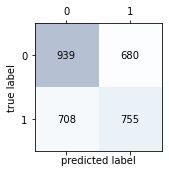

In [28]:
eval_ml_model('Buehler w/ adapt_kliep, Params: Default, Pitch: ' + target_pitch_class, y_test_b, y_pred_b_kleip)

In conclusion, we see that both Recall and F1 scores are improved by the domain adaptation step. However, we might expect a larger performance increase for our efforts . . . more research on this strategy is needed! Will return to this soon.